## Imports

In [1]:
import os

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz

## Data split

- Split the data into 70% train and 30% test portions.

In [2]:
df = pd.read_csv("../data/processed/clean_data.csv").dropna()
df.shape
df.head()
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

X_train, y_train = train_df.drop(columns=["bloom_doy"]), train_df["bloom_doy"]
X_test, y_test = test_df.drop(columns=["bloom_doy"]), test_df["bloom_doy"]

In [3]:
df.describe()

,year,bloom_doy,lat,long,alt,tmax,tmin,prcp,agdd_winter,tmax_winter,tmin_winter,prcp_winter,co2_percapita
count,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000,6182.000000
mean,1986.743449,100.868004,36.839247,126.607992,77.202855,18.177810,9.929257,6.389386,320.095987,8.088522,0.047995,37.123668,7.504484
std,18.669969,22.153055,4.805676,36.900664,152.036007,4.133808,4.474933,5.852501,271.118653,5.171065,5.613492,31.326893,2.941605
min,1950.000000,8.000000,24.336667,-77.038628,0.000000,-1.231429,-6.891667,0.300000,0.000000,-5.361290,-19.231605,0.000000,1.238400
25%,1972.000000,93.000000,34.338333,130.982500,5.700000,15.445254,6.732201,3.472131,107.162500,4.469276,-3.048046,16.643862,5.962850
50%,1987.000000,99.000000,35.535833,136.193333,26.500000,19.180202,10.368247,4.798739,277.550000,8.939666,0.467114,27.195622,7.979900
75%,2002.000000,110.000000,39.698333,140.099167,51.100000,20.695124,12.196861,7.179105,459.062500,11.040633,2.382826,47.833111,9.736200
max,2021.000000,160.000000,47.568867,145.585556,1390.000000,32.300000,26.500000,122.900000,1713.350000,24.032139,18.454031,525.250000,22.236500


## Preprocessing and transformations

- Identify different feature types and the transformations on each feature type.

In [4]:
categorical_features = ["country"]
numeric_features = [
    "lat",
    "long",
    "alt",
    "tmax",
    "tmin",
    "prcp",
    "agdd_winter",
    "tmax_winter",
    "prcp_winter",
    "co2_percapita",
    "year",
]
drop_features = ["city", "country"]
target = "bloom_doy"

- Define a column transformer.

In [5]:
scaler = StandardScaler()
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # scaling on numeric features
    (
    OneHotEncoder(handle_unknown="ignore"),
    categorical_features,
    ),  # OHE on categorical features
    ("drop", drop_features),  # drop features
)

preprocessor.fit_transform(X_train).shape

(4327, 15)

- Define scoring metrics.

In [6]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)


# make a scorer function that we can pass into cross-validation
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


mape_scorer = make_scorer(mape, greater_is_better=False)

In [7]:
scoring_metrics = {
    "neg_RMSE": "neg_root_mean_squared_error",
    "r2": "r2",
    "mape": mape_scorer,
}

## Models

- Make pipelines for all the regression models and store in "models" dictionary.
    - Baseline: A regressor that makes predictions using simple rules. This regressor is useful as a simple baseline to compare with other (real) regressors. 
    - Ridge: A regressor with the loss function as the linear least squares function and regularization as the l2-norm. 
    - Decision Tree: A regressor that builds regression models in the form of a tree structure. It breaks down a data set into smaller subsets while at the same time an associated decision tree is incrementally developed.
    - LGBM: A gradient boosting framework based on decision trees to increase the efficiency of the model and reduce memory usage.
    - CatBoost: An algorithm for gradient boosting on decision trees.
    - Support Vector: A regressor that works on the principle of SVM and tries to fit the best line within a threshold value.
    - KNN: A non-parametric method that approximates the association between independent variables and the outcome by averaging the observations in the same neighborhood.

In [8]:
models = {
    "Baseline": make_pipeline(preprocessor, DummyRegressor()),
    "Ridge": make_pipeline(preprocessor, Ridge(random_state=123)),
    "Lasso": make_pipeline(preprocessor, Lasso(random_state=123)),
    "Decision Tree": make_pipeline(
        preprocessor, DecisionTreeRegressor(random_state=123)
    ),
    "LGBM": make_pipeline(preprocessor, LGBMRegressor(random_state=123)),
    "CatBoost": make_pipeline(
        preprocessor, CatBoostRegressor(verbose=0, random_state=123)
    ),
    "Support Vector": make_pipeline(preprocessor, SVR(epsilon=0.2)),
    "KNN": make_pipeline(
        preprocessor,
        KNeighborsRegressor(n_neighbors=30, weights="uniform", algorithm="auto"),
    ),
}

## Cross validation

- Use root mean squared error (RMSE), R-squared, and mean absolute percentage error (MAPE) as criteria to perform cross validation. 
    - Interpretation of the results: We can see that based on RMSE, MAPE, and R-squared, Cat Boost Regression performed the best.

In [9]:
results = {}  # dictionary to store all the results

In [10]:
# saving the mean cross validation scores in resutls dictionary created previously
for model_name, model in models.items():
    results[model_name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        scoring=scoring_metrics,
        return_train_score=True,
    )

In [11]:
pd.DataFrame(results).rename(
    index={"test_neg RMSE": "cv_neg_RMSE", "test_r2": "cv_r2", "test_mape": "cv_mape"}
).drop(["fit_time", "score_time"])

,Baseline,Ridge,Lasso,Decision Tree,LGBM,CatBoost,Support Vector,KNN
test_neg_RMSE,-21.795 (+/- 1.233),-8.324 (+/- 0.329),-9.317 (+/- 0.349),-6.375 (+/- 0.334),-4.121 (+/- 0.137),-3.952 (+/- 0.111),-8.725 (+/- 0.849),-6.580 (+/- 0.315)
train_neg_RMSE,-21.806 (+/- 0.312),-8.283 (+/- 0.082),-9.267 (+/- 0.045),0.000 (+/- 0.000),-2.659 (+/- 0.027),-2.259 (+/- 0.022),-8.579 (+/- 0.105),-6.326 (+/- 0.106)
cv_r2,-0.003 (+/- 0.002),0.853 (+/- 0.010),0.816 (+/- 0.013),0.913 (+/- 0.013),0.964 (+/- 0.004),0.967 (+/- 0.003),0.839 (+/- 0.014),0.908 (+/- 0.011)
train_r2,0.000 (+/- 0.000),0.856 (+/- 0.003),0.819 (+/- 0.004),1.000 (+/- 0.000),0.985 (+/- 0.000),0.989 (+/- 0.000),0.845 (+/- 0.005),0.916 (+/- 0.004)
cv_mape,-21.041 (+/- 2.937),-8.227 (+/- 0.803),-9.214 (+/- 0.985),-5.136 (+/- 0.605),-3.483 (+/- 0.413),-3.368 (+/- 0.338),-8.319 (+/- 1.332),-5.630 (+/- 0.624)
train_mape,-21.031 (+/- 0.605),-8.174 (+/- 0.173),-9.164 (+/- 0.184),0.000 (+/- 0.000),-2.325 (+/- 0.054),-1.986 (+/- 0.027),-8.114 (+/- 0.146),-5.392 (+/- 0.129)


## Hyperparameter Optimization

- Tune hyperparameter for Cat Boost Regression model.
    - Interpretation of the results: We can see that the tuned model did not out-perform the original model with default hyperparameters. Therefore, we chose Cat Boost Regression with default hyperparameters as the final model for the prediction.

In [12]:
import warnings

warnings.filterwarnings("ignore")

cb_param_grid = {
    "catboostregressor__max_depth": [-1, 10, 20, 40, 100, 500],
    "catboostregressor__n_estimators": np.arange(2, 40) * 10,
    "catboostregressor__l2_leaf_reg": np.arange(2, 20),
}

cb_rand = RandomizedSearchCV(
    models["CatBoost"],
    cb_param_grid,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    random_state=123,
    return_train_score=True,
)
cb_random_search = cb_rand.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [13]:
print("Tuned hyper-params for CatBoost:\n", cb_random_search.best_params_)

print("\nTraining and validation scores of CatBoost with the tuned hyper-params:")
pd.DataFrame(cb_random_search.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "rank_test_score",
    ]
].sort_values(by=["rank_test_score"]).drop("rank_test_score", axis=1).rename(
    columns={"mean_test_score": "mean cv score"}
).head(
    1
)

Tuned hyper-params for CatBoost:
 {'catboostregressor__n_estimators': 370, 'catboostregressor__max_depth': 10, 'catboostregressor__l2_leaf_reg': 10}

Training and validation scores of CatBoost with the tuned hyper-params:


,mean_train_score,mean cv score
17,0.969494,0.954432


## Feature Importance

- Use visualization tools to demonstrate feature importance.
    - Interpretation of the 1st graph: The most important features seem to be `lat` and `tmax_winter`. 
    - Interpretation of the 2nd graph: For `lat`, it seems that lower `lat` values mostly have a positive impact on the bloom day. Locations with lower latitude tend to be warmer, leading early bloom dates. On the other hand, `tmax_winter` appears to have a negative impact on the bloom day. Locations with higher maximum winter temperature are more likely to have shorter `bloom_doy`, i.e. early bloom dates.

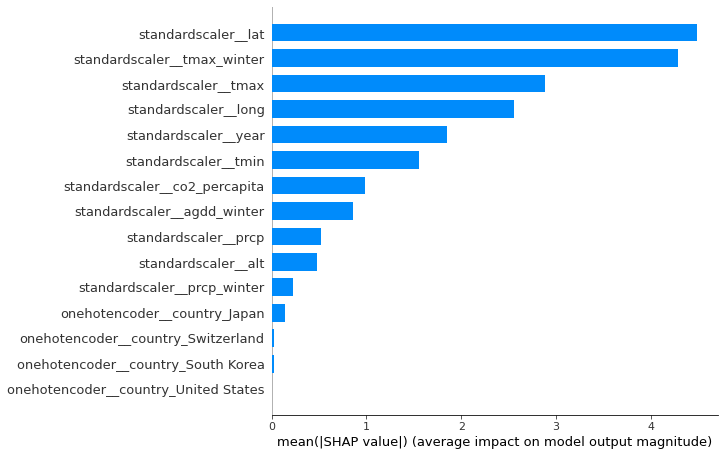

In [14]:
# Fit the preprocessor first
preprocessor.fit(X_train, y_train)

# Get all feature names
feature_names = preprocessor.get_feature_names_out()

# Create encoded train data
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

# Fit regressor model using LGBMRegressor
pipe_cb = make_pipeline(
    preprocessor, CatBoostRegressor(verbose=0, random_state=123)
)
pipe_cb.fit(X_train, y_train)

# Create feature importance visualization using shap
explainer = shap.TreeExplainer(pipe_cb.named_steps["catboostregressor"])
train_shap_values = explainer.shap_values(X_train_enc)
shap.summary_plot(train_shap_values, X_train_enc, plot_type="bar")

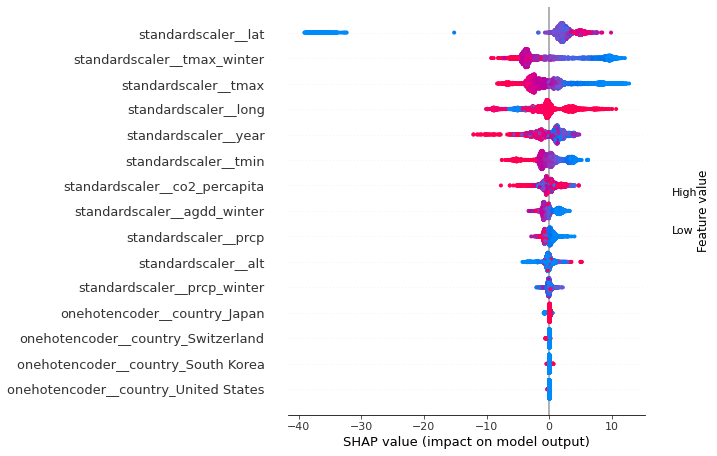

In [20]:
shap.summary_plot(train_shap_values, X_train_enc)

## Test

- Fit test data to the model.

In [16]:
# Predict on the test data and report scores
y_pred = pipe_cb.predict(X_test)
test_scores = {"metrics": list(scoring_metrics.keys()), "best model-lgbm": []}
test_scores["best model-lgbm"].append(
    -1 * mean_squared_error(y_test, y_pred, squared=False)
)
test_scores["best model-lgbm"].append(r2_score(y_test, y_pred))
test_scores["best model-lgbm"].append(mape(y_test, y_pred))
pd.DataFrame(test_scores).set_index("metrics")

,best model-lgbm
metrics,
neg_RMSE,-3.724826
r2,0.973585
mape,3.135065


- Pick one data point from the test data to compare the observed value and the predicted value.
    - Interpretation of the results: From the graph, we can see that the prediction is 94 while the true value is 92. Features such as `lat` (the red ones on the left) are pulling prediction upwards to higher values on the right while features like `tmax_witner`, `tmax`, and 'year' (the blue ones on the right) are pulling the prediction downwards to lower values on the left.

In [17]:
# Create encoded test data
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

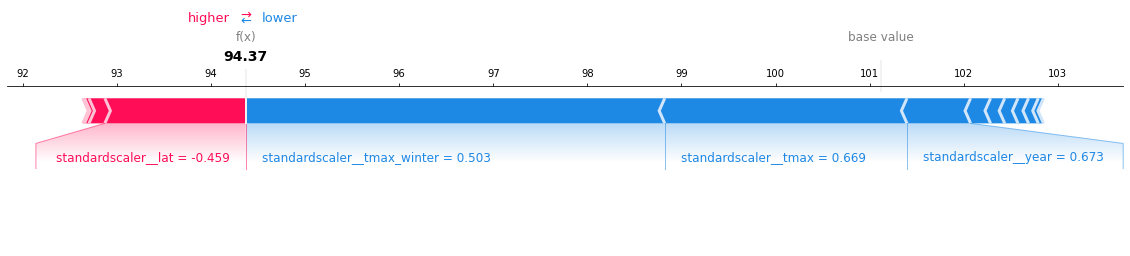

In [18]:
# We are only extracting shapely values for the first 5 test examples for speed.
test_lgbm_shap_values = explainer.shap_values(X_test_enc[:5])

# Round off feature values for better display
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

# An example
shap.force_plot(
    explainer.expected_value,
    test_lgbm_shap_values[4],
    X_test_enc.iloc[4, :],
    matplotlib=True,
)

In [19]:
print("True popularity for case one:", y_test.iloc[4])

True popularity for case one: 92


# Prediction